In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt


In [79]:
df = pd.read_csv('RSCCASN.csv',index_col='DATE',parse_dates=True)

In [80]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [81]:
df.columns = ['Sales']

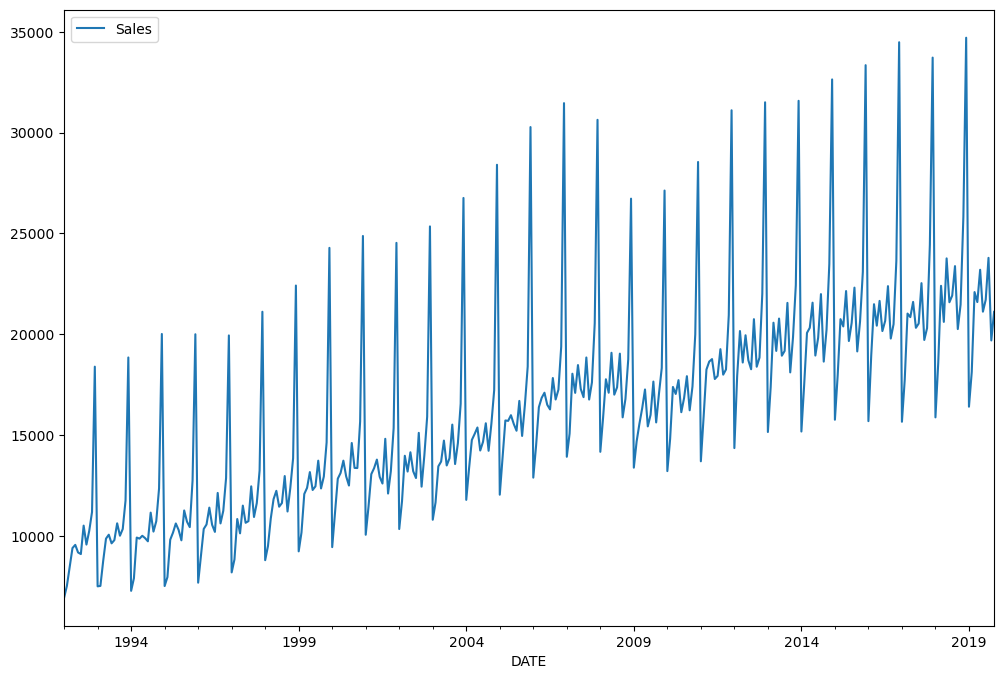

In [82]:
df.plot(figsize=(12,8));

## Répartition Entraînement / Test

In [83]:
len(df)

334

In [84]:
len(df)- 18

316

In [85]:
test_size = 18

In [86]:
test_ind = len(df)- test_size

In [87]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [88]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [89]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


## Mise à l'échelle des données


In [90]:
from sklearn.preprocessing import MinMaxScaler

In [91]:
scaler = MinMaxScaler()

In [92]:
# Si warning, ignorez le, cest juste une conversion en float
# Adapter uniquement aux données d'entraînement, sinon nous trichons en supposant des informations sur les données test
scaler.fit(train)

MinMaxScaler()

In [93]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Générateur de séries temporelles


In [94]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [95]:
# Redéfinissons pour obtenir 12 mois en arrière et prédisons le mois suivant
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

## Création du Modèle

In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [97]:
# Nous n'utilisons qu'une seule feature dans notre série temporelle
n_features = 1 

In [98]:
# définir le modèle
model = Sequential()
model.add(SimpleRNN(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [99]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 100)               10200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


## EarlyStopping et création d'un Générateur de Validation


In [100]:
from tensorflow.keras.callbacks import EarlyStopping

In [101]:
early_stop = EarlyStopping(monitor='val_loss',patience=4)

In [102]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [103]:
# ajustement du modèle
model.fit(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 5s 8ms/step - loss: 0.0249 - val_loss: 0.0354
Epoch 2/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0081 - val_loss: 0.0021
Epoch 3/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0021 - val_loss: 9.2328e-04
Epoch 4/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 5/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0032 - val_loss: 3.6375e-04
Epoch 6/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0017 - val_loss: 0.0102
Epoch 7/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0023 - val_loss: 5.0628e-04
Epoch 8/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0022 - val_loss: 9.6419e-04
Epoch 9/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 4.5842e-04


In [104]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot: >

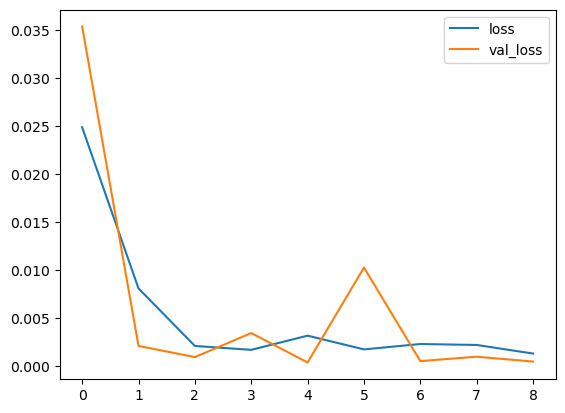

In [105]:
losses.plot()

## Évaluation sur les données de test

In [106]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    test_predictions.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 71ms/step


## Transformations inverses et Comparaison

In [107]:
true_predictions = scaler.inverse_transform(test_predictions)

In [108]:
# Ignorez le warning
test['Predictions'] = true_predictions

C:\Users\HP\AppData\Local\Temp\ipykernel_13228\3589043930.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [109]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22097.646786
2018-06-01,21589,21177.056628
2018-07-01,21919,21867.972481
2018-08-01,23381,22162.903078
2018-09-01,20260,19637.408387
2018-10-01,21473,20721.183603
2018-11-01,25831,23611.793718
2018-12-01,34706,35372.068377
2019-01-01,16410,16829.828974


In [110]:
from sklearn.metrics import mean_squared_error


In [111]:
mse = mean_squared_error(test['Sales'], test['Predictions'])
rmse = np.sqrt(mse)
print(rmse)

939.6898413798625


<AxesSubplot: xlabel='DATE'>

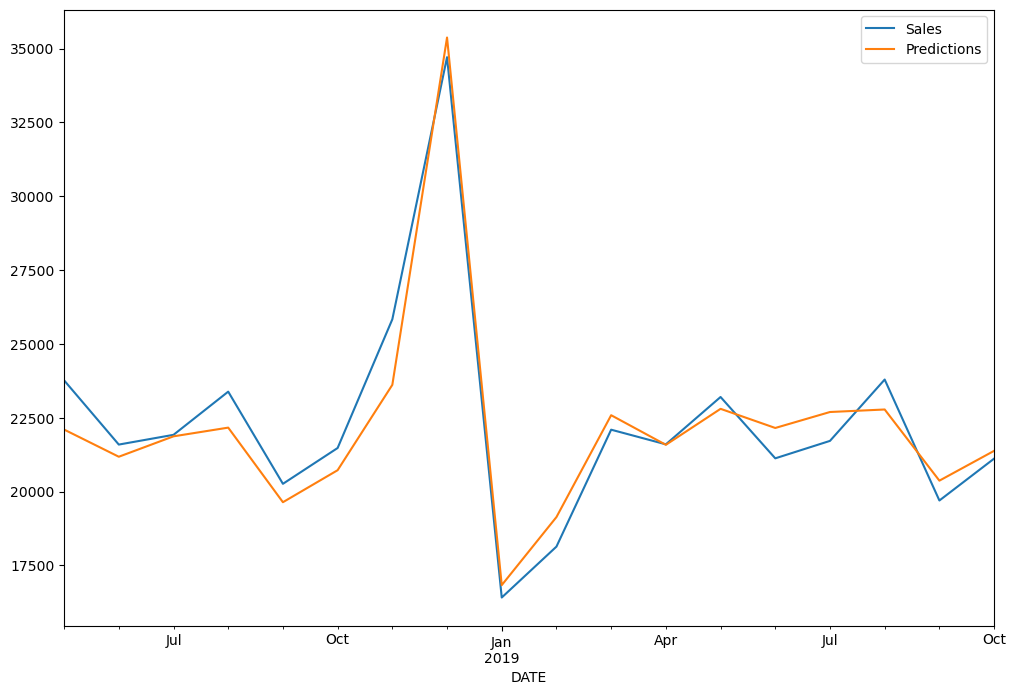

In [112]:
test.plot(figsize=(12,8))

## Ré-Entraînement et Prévision


In [113]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [114]:
length = 12 # Longueur des séquences de sortie (en nombre de pas temporel)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [116]:
model = Sequential()
model.add(SimpleRNN(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# ajustement du modèle
model.fit(generator,epochs=9)

Epoch 1/9
322/322 [==============================] - 4s 6ms/step - loss: 0.0215
Epoch 2/9
322/322 [==============================] - 2s 6ms/step - loss: 0.0087
Epoch 3/9
322/322 [==============================] - 2s 6ms/step - loss: 0.0028
Epoch 4/9
322/322 [==============================] - 2s 5ms/step - loss: 0.0034
Epoch 5/9
322/322 [==============================] - 1s 3ms/step - loss: 0.0014
Epoch 6/9
322/322 [==============================] - 2s 5ms/step - loss: 0.0010
Epoch 7/9
322/322 [==============================] - 2s 5ms/step - loss: 0.0024
Epoch 8/9
322/322 [==============================] - 2s 6ms/step - loss: 9.1481e-04
Epoch 9/9
322/322 [==============================] - 2s 6ms/step - loss: 9.9350e-04


In [117]:
forecast = []
# Remplacez les périodes par la durée de prévision que vous souhaitez
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    forecast.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 56ms/step


In [118]:
forecast = full_scaler.inverse_transform(forecast)

In [120]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [121]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [122]:
forecast_df

,Forecast
2019-11-01,25630.956139
2019-12-01,35436.806879
2020-01-01,16100.840390
2020-02-01,17256.978633
2020-03-01,22161.816473
2020-04-01,20165.515466
2020-05-01,22375.667209
2020-06-01,19585.238439
2020-07-01,19836.957902
2020-08-01,21640.042328


<AxesSubplot: >

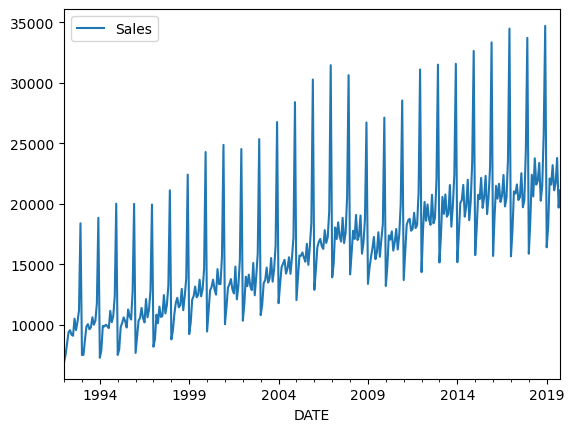

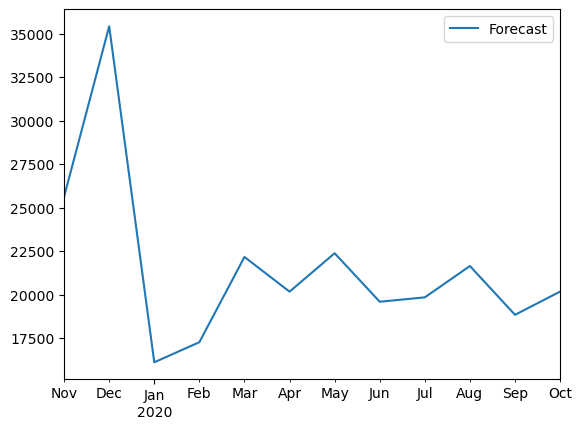

In [123]:
df.plot()
forecast_df.plot()

<AxesSubplot: xlabel='DATE'>

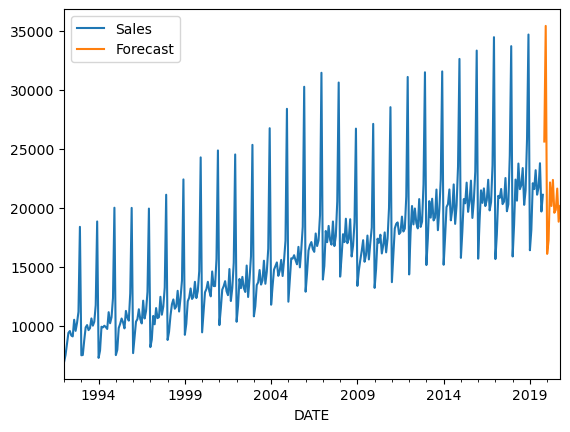

In [124]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

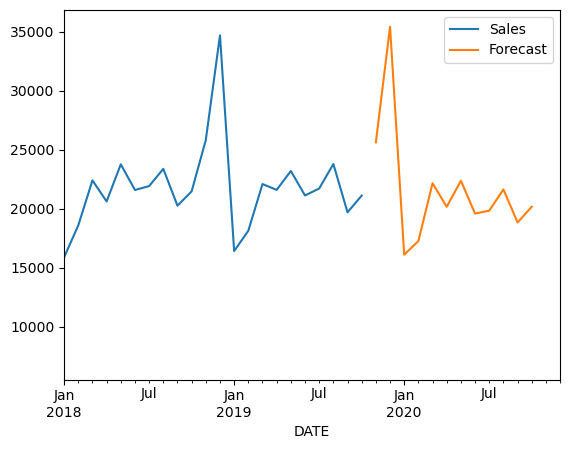

In [126]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')